In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GNNExplainer

import networkx as nx

In [2]:
dataset = 'Cora'
dataset = Planetoid("gnn_data", dataset, transform=T.NormalizeFeatures())
data = dataset[0]

In [3]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
x, edge_index = data.x, data.edge_index

In [5]:
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [6]:
from copy import copy
from math import sqrt
from typing import Optional

import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import k_hop_subgraph, to_networkx

EPS = 1e-15


class GNNExplainer(torch.nn.Module):
    r"""The GNN-Explainer model from the `"GNNExplainer: Generating
    Explanations for Graph Neural Networks"
    <https://arxiv.org/abs/1903.03894>`_ paper for identifying compact subgraph
    structures and small subsets node features that play a crucial role in a
    GNN’s node-predictions.

    .. note::

        For an example of using GNN-Explainer, see `examples/gnn_explainer.py
        <https://github.com/rusty1s/pytorch_geometric/blob/master/examples/
        gnn_explainer.py>`_.

    Args:
        model (torch.nn.Module): The GNN module to explain.
        epochs (int, optional): The number of epochs to train.
            (default: :obj:`100`)
        lr (float, optional): The learning rate to apply.
            (default: :obj:`0.01`)
        num_hops (int, optional): The number of hops the :obj:`model` is
            aggregating information from.
            If set to :obj:`None`, will automatically try to detect this
            information based on the number of
            :class:`~torch_geometric.nn.conv.message_passing.MessagePassing`
            layers inside :obj:`model`. (default: :obj:`None`)
        log (bool, optional): If set to :obj:`False`, will not log any learning
            progress. (default: :obj:`True`)
    """

    coeffs = {
        'edge_size': 0.005,
        'node_feat_size': 1.0,
        'edge_ent': 1.0,
        'node_feat_ent': 0.1,
    }

    def __init__(self, model, epochs: int = 100, lr: float = 0.01,
                 num_hops: Optional[int] = None, log: bool = True):
        super(GNNExplainer, self).__init__()
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.__num_hops__ = num_hops
        self.log = log

    def __set_masks__(self, x, edge_index, init="normal"):
        (N, F), E = x.size(), edge_index.size(1)

        std = 0.1
        self.node_feat_mask = torch.nn.Parameter(torch.randn(F) * 0.1)

        std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))
        self.edge_mask = torch.nn.Parameter(torch.randn(E) * std)

        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = True
                module.__edge_mask__ = self.edge_mask

    def __clear_masks__(self):
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = False
                module.__edge_mask__ = None
        self.node_feat_masks = None
        self.edge_mask = None

    @property
    def num_hops(self):
        if self.__num_hops__ is not None:
            return self.__num_hops__

        k = 0
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                k += 1
        return k

    def __flow__(self):
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                return module.flow
        return 'source_to_target'

    def __subgraph__(self, node_idx, x, edge_index, **kwargs):
        num_nodes, num_edges = x.size(0), edge_index.size(1)

        subset, edge_index, mapping, edge_mask = k_hop_subgraph(
            node_idx, self.num_hops, edge_index, relabel_nodes=True,
            num_nodes=num_nodes, flow=self.__flow__())

        x = x[subset]
        for key, item in kwargs.items():
            if torch.is_tensor(item) and item.size(0) == num_nodes:
                item = item[subset]
            elif torch.is_tensor(item) and item.size(0) == num_edges:
                item = item[edge_mask]
            kwargs[key] = item

        return x, edge_index, mapping, edge_mask, kwargs

    def __loss__(self, node_idx, log_logits, pred_label):
        loss = -log_logits[node_idx, pred_label[node_idx]]

        m = self.edge_mask.sigmoid()
        loss = loss + self.coeffs['edge_size'] * m.sum()
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['edge_ent'] * ent.mean()

        m = self.node_feat_mask.sigmoid()
        loss = loss + self.coeffs['node_feat_size'] * m.sum()
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['node_feat_ent'] * ent.mean()

        return loss

    def explain_node(self, node_idx, x, edge_index, **kwargs):
        r"""Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for node
        :attr:`node_idx`.

        Args:
            node_idx (int): The node to explain.
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.

        :rtype: (:class:`Tensor`, :class:`Tensor`)
        """

        self.model.eval()
        self.__clear_masks__()

        num_edges = edge_index.size(1)

        # Only operate on a k-hop subgraph around `node_idx`.
        x, edge_index, mapping, hard_edge_mask, kwargs = self.__subgraph__(
            node_idx, x, edge_index, **kwargs)

        # Get the initial prediction.
        with torch.no_grad():
            log_logits = self.model(x=x, edge_index=edge_index, **kwargs)
            pred_label = log_logits.argmax(dim=-1)

        self.__set_masks__(x, edge_index)
        self.to(x.device)

        optimizer = torch.optim.Adam([self.node_feat_mask, self.edge_mask],
                                     lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description(f'Explain node {node_idx}')

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            h = x * self.node_feat_mask.view(1, -1).sigmoid()
            log_logits = self.model(x=h, edge_index=edge_index, **kwargs)
            loss = self.__loss__(mapping, log_logits, pred_label)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)

        if self.log:  # pragma: no cover
            pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        edge_mask = self.edge_mask.new_zeros(num_edges)
        edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()

        self.__clear_masks__()

        return node_feat_mask, edge_mask


    def visualize_subgraph(self, node_idx, edge_index, edge_mask, y=None,
                           threshold=None, **kwargs):
        r"""Visualizes the subgraph around :attr:`node_idx` given an edge mask
        :attr:`edge_mask`.

        Args:
            node_idx (int): The node id to explain.
            edge_index (LongTensor): The edge indices.
            edge_mask (Tensor): The edge mask.
            y (Tensor, optional): The ground-truth node-prediction labels used
                as node colorings. (default: :obj:`None`)
            threshold (float, optional): Sets a threshold for visualizing
                important edges. If set to :obj:`None`, will visualize all
                edges with transparancy indicating the importance of edges.
                (default: :obj:`None`)
            **kwargs (optional): Additional arguments passed to
                :func:`nx.draw`.

        :rtype: :class:`matplotlib.axes.Axes`, :class:`networkx.DiGraph`
        """

        assert edge_mask.size(0) == edge_index.size(1)

        # Only operate on a k-hop subgraph around `node_idx`.
        subset, edge_index, _, hard_edge_mask = k_hop_subgraph(
            node_idx, self.num_hops, edge_index, relabel_nodes=True,
            num_nodes=None, flow=self.__flow__())

        edge_mask = edge_mask[hard_edge_mask]

        if threshold is not None:
            edge_mask = (edge_mask >= threshold).to(torch.float)

        if y is None:
            y = torch.zeros(edge_index.max().item() + 1,
                            device=edge_index.device)
        else:
            y = y[subset].to(torch.float) / y.max().item()

        data = Data(edge_index=edge_index, att=edge_mask, y=y,
                    num_nodes=y.size(0)).to('cpu')
        G = to_networkx(data, node_attrs=['y'], edge_attrs=['att'])
        mapping = {k: i for k, i in enumerate(subset.tolist())}
        G = nx.relabel_nodes(G, mapping)

        node_kwargs = copy(kwargs)
        node_kwargs['node_size'] = kwargs.get('node_size') or 800
        node_kwargs['cmap'] = kwargs.get('cmap') or 'cool'

        label_kwargs = copy(kwargs)
        label_kwargs['font_size'] = kwargs.get('font_size') or 10

        pos = nx.spring_layout(G)
        ax = plt.gca()
        for source, target, data in G.edges(data=True):
            ax.annotate(
                '', xy=pos[target], xycoords='data', xytext=pos[source],
                textcoords='data', arrowprops=dict(
                    arrowstyle="->",
                    alpha=max(data['att'], 0.1),
                    shrinkA=sqrt(node_kwargs['node_size']) / 2.0,
                    shrinkB=sqrt(node_kwargs['node_size']) / 2.0,
                    connectionstyle="arc3,rad=0.1",
                ))
        nx.draw_networkx_nodes(G, pos, node_color=y.tolist(), **node_kwargs)
        nx.draw_networkx_labels(G, pos, **label_kwargs)

        return ax, G


    def __repr__(self):
        return f'{self.__class__.__name__}()'

In [7]:
explainer = GNNExplainer(model, epochs=200)

In [8]:
node_idx = 10
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)

Explain node 10: 100%|██████████| 200/200 [00:01<00:00, 112.15it/s]


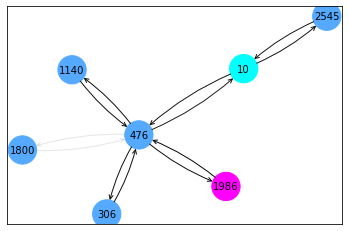

In [9]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()